## Imports

In [1]:
import copy
import glob
import importlib
import math
import os
import random
import shutil
import sys
from math import degrees, pi, radians
from os.path import *

import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import SimpleITK as sitk
import skimage.feature as skf
from skimage.morphology import ball

import cnn_builder as cbuild
import config
import lipiodol_methods as lm
import niftiutils.helper_fxns as hf
import niftiutils.liver_metrics as lmet
import niftiutils.masks as masks
import niftiutils.registration as reg
import niftiutils.transforms as tr
from config import Config

%matplotlib inline

C:\Users\Clinton\AppData\Local\conda\conda\envs\old-keras\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
importlib.reload(hf)
C = config.Config()

In [3]:
img_dir = "D:\\Lipiodol\\Images all"
seg_dir = "D:\\Lipiodol\\Images extracted and segmentations"
target_dir = "D:\\Lipiodol\\Data"

## Pattern analysis

In [ ]:
(PK2 image)

In [47]:
patient_id = "PK-02"
importlib.reload(lm)
paths = lm.get_paths(patient_id, target_dir, check_valid=False)

mask_dir, nii_dir, ct24_path, ct24_tumor_mask_path, ct24_liver_mask_path, \
mribl_art_path, mribl_pre_path, \
mribl_tumor_mask_path, mribl_liver_mask_path, \
mribl_enh_mask_path, mribl_nec_mask_path, \
mri30d_art_path, mri30d_pre_path, \
mri30d_tumor_mask_path, mri30d_liver_mask_path, \
mri30d_enh_mask_path, mri30d_nec_mask_path, \
ball_ct24_path, ball_mribl_path, ball_mri30d_path, \
ball_mask_path, ball_mribl_enh_mask_path, ball_mri30d_enh_mask_path, \
midlip_mask_path, ball_midlip_mask_path, \
highlip_mask_path, ball_highlip_mask_path = paths

ctmask,ctd = masks.get_mask(ct24_tumor_mask_path, img_path=ct24_path)
mrmask,mrd = masks.get_mask(mribl_tumor_mask_path, img_path=mribl_art_path)
ctmask = hf.crop_nonzero(ctmask)[0]
mrmask = hf.crop_nonzero(mrmask)[0]
mask_scale = (ctmask.sum()*np.product(ctd) / (mrmask.sum()*np.product(mrd)))**(1/6)
CT = np.max([ctmask.shape[i] * ctd[i] / mask_scale for i in range(3)])
MRBL = np.max([mrmask.shape[i] * mrd[i] for i in range(3)])

mrmask,mrd = masks.get_mask(mri30d_tumor_mask_path, img_path=mri30d_art_path)
mrmask = hf.crop_nonzero(mrmask)[0]
MR30 = np.max([mrmask.shape[i] * mrd[i] for i in range(3)])

In [49]:
xform_path, crops, pads = reg.get_mask_Tx_shape(mribl_art_path, mribl_tumor_mask_path, ball_mask_path=ball_mask_path)

In [53]:
_ = reg.transform_mask(mribl_enh_mask_path, mribl_art_path, xform_path,
                         crops, pads, [1.]*3, ball_mribl_enh_mask_path)

In [59]:
img, img_dims = hf.nii_load(mribl_art_path)
mask, mask_dims = masks.get_mask(mribl_enh_mask_path, img_dims, img.shape)
crops_m, crops_f = crops
pads_m, pads_f = pads

mask, _ = hf.crop_nonzero(mask, crops_m)
mask, _ = tr.rescale_img(mask, [1.]*3, mask_dims)
mask = np.pad(mask, pads_m, 'constant')

In [60]:
mask.shape

(98, 99, 99)

In [57]:
hf.nii_load(mov_tmp_path)[0].shape

(98, 99, 99)

### Build DataFrame

In [37]:
df = pd.DataFrame(columns=["enhancing_vol%", "lipcoverage_vol%",
                           "rim_enhancing%", "rim_lipiodol%",
                           "mribl_sum_entropy", "mribl_entropy", "mribl_diff_entropy",
                           "midlip_sum_entropy", "midlip_entropy", "midlip_diff_entropy"])

In [88]:
importlib.reload(lm)

<module 'lipiodol_methods' from 'C:\\Users\\Clinton\\Documents\\Lipiodol\\lipiodol_methods.py'>

In [62]:
[basename(fn) for fn in glob.glob(join(target_dir,"*"))].index('PK-02')

27

In [ ]:
importlib.reload(lm)
for fn in glob.glob(join(target_dir,"*"))[27:]:
    patient_id = basename(fn)
    print(patient_id)
    lm.spherize(patient_id, target_dir)
    df.loc[patient_id] = lm.get_row_entry(patient_id, target_dir)

PK-02


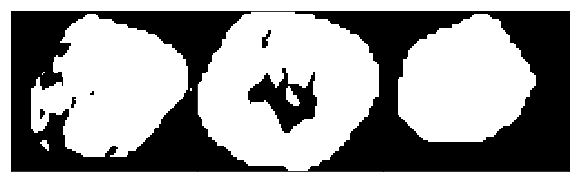

In [46]:
masks.draw_mask(mribl_enh_mask_path)

paths = lm.get_paths(patient_id, target_dir)

mask_dir, nii_dir, ct24_path, ct24_tumor_mask_path, ct24_liver_mask_path, \
mribl_art_path, mribl_pre_path, \
mribl_tumor_mask_path, mribl_liver_mask_path, \
mribl_enh_mask_path, mribl_nec_mask_path, \
mri30d_art_path, mri30d_pre_path, \
mri30d_tumor_mask_path, mri30d_liver_mask_path, \
mri30d_enh_mask_path, mri30d_nec_mask_path, \
ball_ct24_path, ball_mribl_path, ball_mri30d_path, \
ball_mask_path, ball_mribl_enh_mask_path, ball_mri30d_enh_mask_path, \
midlip_mask_path, ball_midlip_mask_path, \
highlip_mask_path, ball_highlip_mask_path = paths

ctmask,ctd = masks.get_mask(ct24_tumor_mask_path, img_path=ct24_path)
mrmask,mrd = masks.get_mask(mribl_tumor_mask_path, img_path=mribl_art_path)
mask_scale = (ctmask.sum()*np.product(ctd) / (mrmask.sum()*np.product(mrd)))**(1/6)
ctmask
CT = np.max([ctmask.shape[i] * ctd[i] / mask_scale for i in range(3)])
MRBL = np.max([mrmask.shape[i] * mrd[i] for i in range(3)])

mrmask,mrd = masks.get_mask(mri30d_tumor_mask_path, img_path=mri30d_art_path)
MR30 = np.max([mrmask.shape[i] * mrd[i] for i in range(3)])

CT, MRBL, MR30

xform_path, crops, pads = reg.get_mask_Tx_shape(mri30d_art_path, mri30d_tumor_mask_path, mask_path=ball_mask_path)

target_shape = masks.get_mask(ball_mask_path)[0].shape

_ = reg.transform_region(mri30d_art_path, xform_path, crops, pads, [1.]*3, ball_mri30d_path, target_shape=target_shape)
_ = reg.transform_mask(mri30d_enh_mask_path, mri30d_art_path, xform_path,
                     crops, pads, [1.]*3, ball_mri30d_enh_mask_path)

masks.get_mask(ball_mask_path)[0].shape

## Create mini-DICOMs

In [ ]:
output_directory = "D:\\rim_ranking"
output_directory = "D:\\sparsity_ranking"
output_directory = "D:\\heterogeneity_ranking"
sorted()

In [ ]:
def write_ranked_imgs(df, column, root_dir, ):
    for ix,row in df.sort_values(["length"], ascending=False).iterrows():
        save_dir = "%d_%s" % (row[column], ix)
        img = tr.apply_window(img)
        hf.create_dicom(img, save_dir, overwrite=True)

In [ ]:
importlib.reload(hf)

## Figures

In [ ]:
lm.draw_unreg_fig(mribl_art_path, mribl_enh_mask_path, "D:\\Lipiodol\\Figures\\unreg\\MRIBL", 'b', 'mr')
lm.draw_unreg_fig(mri30d_art_path, mri30d_enh_mask_path, "D:\\Lipiodol\\Figures\\unreg\\MRI30d", 'r', 'mr')
lm.draw_unreg_fig(ct24_path, highlip_mask_path, "D:\\Lipiodol\\Figures\\unreg\\Lip", 'g', 'ct')

In [ ]:
lm.draw_reg_fig(ball_mribl_path, ball_mribl_enh_mask_path, "D:\\Lipiodol\\Figures\\MRIBL", 'b', 'mr')
lm.draw_reg_fig(ball_mri30d_path, ball_mri30d_enh_mask_path, "D:\\Lipiodol\\Figures\\MRI30d", 'r', 'mr')
lm.draw_reg_fig(ball_ct24_path, ball_highlip_mask_path, "D:\\Lipiodol\\Figures\\Lip", 'g', 'ct')

In [ ]:
# Figure for 24h CT
img,_ = hf.nii_load(ball_ct24_path)
blmask,_ = masks.get_mask(ball_mribl_enh_mask_path)
fumask,_ = masks.get_mask(ball_mri30d_enh_mask_path)

for sl in range(img.shape[-1]//4,img.shape[-1]*3//4,img.shape[-1]//12):
    plt.close()
    plt.imshow(img[...,sl], cmap='gray', vmin=30, vmax=250)
    FU=plt.contour(fumask[:,:,sl], colors='r', alpha=.4)
    plt.contour(blmask[:,:,sl], colors='b', alpha=.4)
    plt.contourf(fumask[:,:,sl], colors=[(0,0,0,0)]*6+[(1,0,0,.2)]) #look at the length of FU.allsegs
    plt.contourf(blmask[:,:,sl], colors=[(0,0,0,0)]*6+[(0,0,1,.2)])
    plt.axis('off')
    plt.savefig("D:\\Lipiodol\\Figures\\24hCT_%d.png" % sl, dpi=100, bbox_inches='tight')

## Extra

IVs = get_intensity_section(ball_ct24_path, ball_mask_path, params)
            if highest_I_V < I_V:
                best_params = params
                highest_I_V = I_V
                print(best_params)
theta1_best, phi1_best, dtheta_best, dz_best = best_params

In [ ]:
ball_IV = get_avg_ball_intensity(ball_ct24_path, ball_mask_path)
core_IV = get_avg_core_intensity(ball_ct24_path, ball_mask_path)

In [303]:
ball_IV, core_IV

(197.83461276161094, 209.89937589866474)

In [ ]:
importlib.reload(lm)
IVs = lm.calc_intensity_shells_angles(hf.nii_load(ball_ct24_path)[0], ball_mask_path)
IVs[IVs==0] = np.nan

samples = lm.fibonacci_sphere(2500, True, randomize=True)
samples = np.round(samples).astype(int)
s0 = samples[:,0]
s1 = samples[:,1]
for i in range(IVs.shape[-1]):
    print(np.nanmean(IVs[s0,s1,i]))

In [388]:
loopIVs = np.tile(IVs[:-1,:-1,:], (2,2,1))
loopIVs[180:,:,:] = np.nan

In [ ]:
for dtheta in range(30,180,20):
    print(dtheta)
    best_IV = core_IV
    worst_IV = core_IV
    for theta in range(0,180,20):
        for phi in range(180,480,20):
            for shell1 in range(4):
                for shell2 in range(shell1+1,5):
                    IV = np.nanmean(loopIVs[max(theta-dtheta,0) : theta+dtheta, phi-dtheta : phi+dtheta, shell1:shell2])
                    params = theta, phi % 360, shell1, shell2
                    if best_IV < IV:
                        best_params = params
                        best_IV = IV
                        
            IV = np.nanmean(loopIVs[max(theta-dtheta,0) : theta+dtheta, phi-dtheta : phi+dtheta, :5])
            params = theta, phi % 360
            if worst_IV > IV:
                worst_params = params
                worst_IV = IV
                
    print(best_params, round(best_IV,1))
    print(worst_params, round(worst_IV,1))

In [ ]:
importlib.reload(lm)
enhmask_density = lm.calc_intensity_shells_angles(masks.get_mask(ball_mribl_enh_mask_path)[0]+1, ball_mask_path)

enhmask_density = enhmask_density[...,:5]
enhmask_density[enhmask_density==0] = np.nan

samples = fibonacci_sphere(2500, True, randomize=True)
samples = np.round(samples).astype(int)
s0 = samples[:,0]
s1 = samples[:,1]
for i in range(enhmask_density.shape[-1]):
    print(np.nanmean(enhmask_density[s0,s1,i]))

In [ ]:
importlib.reload(lm)
enhmask_density = lm.calc_intensity_shells_angles(masks.get_mask(ball_mri30d_enh_mask_path)[0]+1, ball_mask_path)

enhmask_density = enhmask_density[...,:5]
enhmask_density[enhmask_density==0] = np.nan

samples = fibonacci_sphere(2500, True, randomize=True)
samples = np.round(samples).astype(int)
s0 = samples[:,0]
s1 = samples[:,1]
for i in range(enhmask_density.shape[-1]):
    print(np.nanmean(enhmask_density[s0,s1,i]))

In [ ]:
for i in range(enhmask_density.shape[-1]):
    print(np.nanmean(enhmask_density[s0,s1,i]))

In [ ]:
enhmask_density =

In [ ]:
conv_rate = np.zeros((181,360))